> This NB has KNN and SVC

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from utils.subspace_clustering_helper_funcs import *
from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *
from utils.ml_pipeline import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

# Load in Data

In [3]:
print("Loading")

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"
both_pca40_dir = "Both_PCA40\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_pca_training_users_df = pd.read_pickle(data_path+both_pca40_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_pca_test_users_df = pd.read_pickle(data_path+both_pca40_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [4]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

In [5]:
print(emg_training_users_df.shape)
emg_training_users_df.head()

(160000, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [6]:
print(both_training_users_df.shape)
both_training_users_df.head()

(160000, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.551109,-0.738972,-0.985439,0.181924,0.059616,0.087024,1.055804,-0.883268,-0.327978,-0.221822,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.571115,-0.821726,-0.975036,0.242607,0.067375,-0.024900,1.007074,-0.944195,-0.363602,-0.149833,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.509305,-0.823575,-0.947221,0.550111,0.013848,-0.485765,0.993332,-0.944029,-0.357476,-0.164447,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.511788,-0.775810,-0.947939,0.417919,0.087222,-0.229441,1.026003,-0.911993,-0.335594,-0.006214,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.441369,-0.921726,-0.882652,1.254970,0.108993,-0.933639,1.001748,-0.939228,-0.357917,0.009543,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [7]:
print(both_pca_training_users_df.shape)
both_pca_training_users_df.head()

(160000, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.030730,-0.052976,0.176556,-0.048078,-0.390790,-2.119829,0.875118,-0.187689,0.685004,0.870080,...,-0.253283,-0.248582,0.283079,-0.178321,-0.087101,-0.027081,0.000970,0.124380,-0.100580,-0.119294
1,0.077533,-0.108477,0.128970,-0.032167,-0.182756,-1.604412,0.701500,-0.068443,0.667338,1.098287,...,-0.423007,0.097453,0.184025,0.027788,0.112078,-0.414946,-0.210576,0.277156,0.051190,-0.039548
2,0.268279,-0.369027,0.268750,0.105239,-0.190292,-2.093812,1.012038,-0.080958,0.510502,0.758940,...,-0.311882,0.138655,-0.067485,0.201313,-0.051898,-0.479894,-0.079818,0.398142,0.058779,-0.095208
3,-0.106155,-0.291958,0.270681,0.035371,-0.204143,-2.314179,0.801514,-0.155267,0.519967,0.523683,...,-0.585487,-0.100021,0.082335,0.042349,-0.179251,-0.106235,-0.034940,0.386797,-0.034177,-0.132103
4,0.673338,-0.345606,0.246740,0.238184,0.948365,-0.041183,0.279347,0.034288,1.173712,2.115719,...,-0.262556,0.011353,-0.353489,0.209535,-0.402682,-0.353866,0.106203,0.366540,0.218785,-0.080414


Make the dataloaders for the autoencoders

In [8]:
# CREATE THE TRAINING SET
num_gestures = len(emg_training_users_df) // num_rows_per_gesture
num_full_emg_features = emg_training_users_df.shape[1]
emg_train_loader = create_data_loader(emg_training_users_df, GestureDatasetAE, num_gestures, num_rows_per_gesture, num_full_emg_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_test_gestures = len(emg_test_users_df) // num_rows_per_gesture
emg_test_loader = create_data_loader(emg_test_users_df, GestureDatasetAE, num_test_gestures, num_rows_per_gesture, num_full_emg_features, batch_size, shuffle=False)

# CREATE THE TRAINING SET
num_gestures = len(both_training_users_df) // num_rows_per_gesture
num_full_both_features = both_training_users_df.shape[1]
both_train_loader = create_data_loader(both_training_users_df, GestureDatasetAE, num_gestures, num_rows_per_gesture, num_full_both_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_test_gestures = len(both_test_users_df) // num_rows_per_gesture
both_test_loader = create_data_loader(both_test_users_df, GestureDatasetAE, num_test_gestures, num_rows_per_gesture, num_full_both_features, batch_size, shuffle=False)

# CREATE THE TRAINING SET
num_gestures = len(both_pca_training_users_df) // num_rows_per_gesture
num_both_pca_features = both_pca_training_users_df.shape[1]
both_pca_train_loader = create_data_loader(both_pca_training_users_df, GestureDatasetAE, num_gestures, num_rows_per_gesture, num_both_pca_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_test_gestures = len(both_pca_test_users_df) // num_rows_per_gesture
both_pca_test_loader = create_data_loader(both_pca_test_users_df, GestureDatasetAE, num_test_gestures, num_rows_per_gesture, num_both_pca_features, batch_size, shuffle=False)

In [9]:
hidden_dim_lst = [64, 22]
input_dim = 88
RNNAE_64_22mir_BothFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_64_22mir_BothFull.load_state_dict(torch.load(model_dir_path+'RNNAE_64_22mir_vallossp262_BothFull.pth'))

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(RNNAE_64_22mir_BothFull, both_test_loader)

latent_representations = np.concatenate(latent_representations_lst)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)


Average testing loss across the entire test_loader: 0.26212913915514946


In [10]:
hidden_dim_lst = [56, 28]
input_dim = 40
RNNAE_56_28mir_BothPCA40 = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_56_28mir_BothPCA40.load_state_dict(torch.load(model_dir_path+'RNNAE_56_28mir_vallossp419_BothPCA40.pth'))

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(RNNAE_56_28mir_BothPCA40, both_pca_test_loader)

latent_representations = np.concatenate(latent_representations_lst)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)


Average testing loss across the entire test_loader: 0.41911541670560837


In [11]:
hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(RNNAE_9mir_EMGFull, emg_test_loader)

latent_representations = np.concatenate(latent_representations_lst)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)


Average testing loss across the entire test_loader: 0.2774711867625063


One hot encode
> All datasets have the same number of rows and thus the same label sets (they only differ in the number of columns!)

In [12]:
emg_test_users_df.head()

,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
6400,-0.590579,-0.287949,-0.306210,-0.286026,-0.067811,-0.022725,-0.030116,-0.301059,-5.375536,-0.672272,0.003550,-0.034412,-0.015434,-0.004368,-0.132297,-0.127927
6401,-0.538529,-0.316620,-0.312567,-0.225234,-0.040725,-0.002531,-0.050021,-0.234298,-5.365962,-0.618651,0.022224,-0.002252,-0.007844,-0.018952,0.016946,-0.093420
6402,-0.521673,-0.321927,-0.321917,-0.383057,-0.026380,0.003411,-0.021233,-0.146613,-5.357741,-0.599404,-0.006983,-0.036363,-0.015657,-0.009868,0.270363,0.301810
6403,-0.274550,-0.283360,-0.290955,-0.607226,-0.048867,-0.005800,0.011060,0.036846,-5.534573,-0.600492,-0.006797,0.041818,0.001948,0.004594,0.287805,0.519149
6404,-0.203965,-0.305826,-0.301109,-0.372556,-0.062966,0.004885,-0.009311,-0.093618,-5.317473,-0.602479,0.040034,0.045638,0.013134,0.015332,-0.016407,-0.127118


In [13]:
emg_train_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl')
emg_test_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl')
emg_train_gesture_labels_df = emg_train_df['Gesture_ID']
emg_test_gesture_labels_df = emg_test_df['Gesture_ID']

both_train_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl')
both_test_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl')
both_train_gesture_labels_df = both_train_df['Gesture_ID']
both_test_gesture_labels_df = both_test_df['Gesture_ID']

both_pca_train_df = pd.read_pickle(data_path+both_pca40_dir+'training_users_df.pkl')
both_pca_test_df = pd.read_pickle(data_path+both_pca40_dir+'test_users_df.pkl')
both_pca_train_gesture_labels_df = both_pca_train_df['Gesture_ID']
both_pca_test_gesture_labels_df = both_pca_test_df['Gesture_ID']


In [14]:
print(emg_train_gesture_labels_df.shape)
print(emg_test_gesture_labels_df.shape)
print(both_train_gesture_labels_df.shape)
print(both_test_gesture_labels_df.shape)
print(both_pca_train_gesture_labels_df.shape)
print(both_pca_test_gesture_labels_df.shape)

(160000,)
(44800,)
(160000,)
(44800,)
(160000,)
(44800,)


In [15]:
all_train_test_gestures_df = pd.concat([emg_train_gesture_labels_df, emg_test_gesture_labels_df], axis=0)
unique_gestures = all_train_test_gestures_df.unique()
print(len(unique_gestures))
print(unique_gestures)

10
['pan' 'duplicate' 'zoom-out' 'zoom-in' 'move' 'rotate' 'select-single'
 'delete' 'close' 'open']


In [16]:
all_train_test_gestures_df = pd.concat([both_train_gesture_labels_df, both_test_gesture_labels_df], axis=0)
unique_gestures = all_train_test_gestures_df.unique()
print(len(unique_gestures))
print(unique_gestures)

10
['pan' 'duplicate' 'zoom-out' 'zoom-in' 'move' 'rotate' 'select-single'
 'delete' 'close' 'open']


In [17]:
all_train_test_gestures_df = pd.concat([both_pca_train_gesture_labels_df, both_pca_test_gesture_labels_df], axis=0)
unique_gestures = all_train_test_gestures_df.unique()
print(len(unique_gestures))
print(unique_gestures)

10
['pan' 'duplicate' 'zoom-out' 'zoom-in' 'move' 'rotate' 'select-single'
 'delete' 'close' 'open']


Create OneHotEncoder

In [18]:
# Numpy array version (not used rn)

## Create OneHotEncoder instance
#gesture_encoder = OneHotEncoder(sparse=False)
#gesture_labels_reshaped = unique_gestures.reshape(-1, 1)
#gesture_encoded = gesture_encoder.fit_transform(gesture_labels_reshaped)
#print(gesture_encoded)

In [19]:
label_per_gesture_df = both_pca_train_gesture_labels_df.iloc[::num_rows_per_gesture]
print(label_per_gesture_df.shape)
label_per_gesture_df.head()

(2500,)


0      pan
64     pan
128    pan
192    pan
256    pan
Name: Gesture_ID, dtype: object

In [20]:
# TRAIN LABELS (OHE)
labels_array = label_per_gesture_df.to_numpy()
gesture_encoder = OneHotEncoder(sparse=False)
labels_reshaped = labels_array.reshape(-1, 1)
labels_encoded = gesture_encoder.fit_transform(labels_reshaped)
encoded_labels_df = pd.DataFrame(labels_encoded, columns=gesture_encoder.categories_[0])

# TEST LABELS (OHE)
label_per_test_gesture_df = both_pca_test_gesture_labels_df.iloc[::num_rows_per_gesture]
gesture_encoder = OneHotEncoder(sparse=False)
test_labels_encoded = gesture_encoder.fit_transform(label_per_test_gesture_df.to_numpy().reshape(-1, 1))
encoded_test_labels_df = pd.DataFrame(test_labels_encoded, columns=gesture_encoder.categories_[0])

print(encoded_labels_df.shape)
encoded_labels_df.head()

(2500, 10)


,close,delete,duplicate,move,open,pan,rotate,select-single,zoom-in,zoom-out
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
X_3DTensor_full_emg = torch.tensor(emg_training_users_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_full_emg_features), dtype=torch.float32)
Xtest_3DTensor_full_emg = torch.tensor(emg_test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_full_emg_features), dtype=torch.float32)

X_3DTensor_full_both = torch.tensor(both_training_users_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_full_both_features), dtype=torch.float32)
Xtest_3DTensor_full_both = torch.tensor(both_test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_full_both_features), dtype=torch.float32)

X_3DTensor_both_PCA40 = torch.tensor(both_pca_training_users_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_both_pca_features), dtype=torch.float32)
Xtest_3DTensor_both_PCA40 = torch.tensor(both_pca_test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_both_pca_features), dtype=torch.float32)

## Latent Space Clustering

In [22]:
train_embedding = RNNAE_9mir_EMGFull.encode(X_3DTensor_full_emg)
test_embedding = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_full_emg)
X_full_emg_train_embeddings = train_embedding.reshape(train_embedding.shape[0], -1).detach().numpy()
X_full_emg_test_embeddings = test_embedding.reshape(test_embedding.shape[0], -1).detach().numpy()

train_embedding = RNNAE_64_22mir_BothFull.encode(X_3DTensor_full_both)
test_embedding = RNNAE_64_22mir_BothFull.encode(Xtest_3DTensor_full_both)
X_full_both_train_embeddings = train_embedding.reshape(train_embedding.shape[0], -1).detach().numpy()
X_full_both_test_embeddings = test_embedding.reshape(test_embedding.shape[0], -1).detach().numpy()

train_embedding = RNNAE_56_28mir_BothPCA40.encode(X_3DTensor_both_PCA40)
test_embedding = RNNAE_56_28mir_BothPCA40.encode(Xtest_3DTensor_both_PCA40)
X_both_PCA40_train_embeddings = train_embedding.reshape(train_embedding.shape[0], -1).detach().numpy()
X_both_PCA40_test_embeddings = test_embedding.reshape(test_embedding.shape[0], -1).detach().numpy()

print(f"X_full_emg_train_embeddings shape: {X_full_emg_train_embeddings.shape}")
print(f"X_full_emg_test_embeddings shape: {X_full_emg_test_embeddings.shape}")
print(f"X_full_both_train_embeddings shape: {X_full_both_train_embeddings.shape}")
print(f"X_full_both_test_embeddings shape: {X_full_both_test_embeddings.shape}")
print(f"X_both_PCA40_train_embeddings shape: {X_both_PCA40_train_embeddings.shape}")
print(f"X_both_PCA40_test_embeddings shape: {X_both_PCA40_test_embeddings.shape}")
print()
print(f"encoded_labels_df shape: {encoded_labels_df.shape}")
print(f"encoded_test_labels_df shape: {encoded_test_labels_df.shape}")

X_full_emg_train_embeddings shape: (2500, 576)
X_full_emg_test_embeddings shape: (700, 576)
X_full_both_train_embeddings shape: (2500, 1408)
X_full_both_test_embeddings shape: (700, 1408)
X_both_PCA40_train_embeddings shape: (2500, 1792)
X_both_PCA40_test_embeddings shape: (700, 1792)

encoded_labels_df shape: (2500, 10)
encoded_test_labels_df shape: (700, 10)


> __KNN__

In [23]:
def knn_accuracy_vs_num_neighbors(X_train, y_train, X_test, y_test, k_range=range(1, 21)):
    accuracies = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        accuracies.append(accuracy)
        print(f'k={k}, Accuracy: {accuracy*100:.2f}%')

    # Plot the accuracies for each k
    plt.plot(k_range, accuracies, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy vs Number of Neighbors')
    plt.grid(True)
    plt.show()
    
    return accuracies

k=1, Accuracy: 10.14%
k=2, Accuracy: 3.57%
k=3, Accuracy: 6.57%
k=4, Accuracy: 2.71%
k=5, Accuracy: 4.00%
k=6, Accuracy: 1.71%
k=7, Accuracy: 2.86%
k=8, Accuracy: 1.14%
k=9, Accuracy: 1.57%
k=10, Accuracy: 1.29%
k=11, Accuracy: 1.43%
k=12, Accuracy: 1.00%
k=13, Accuracy: 1.57%
k=14, Accuracy: 0.57%
k=15, Accuracy: 1.00%
k=16, Accuracy: 0.43%
k=17, Accuracy: 0.86%
k=18, Accuracy: 0.43%
k=19, Accuracy: 1.00%
k=20, Accuracy: 0.71%


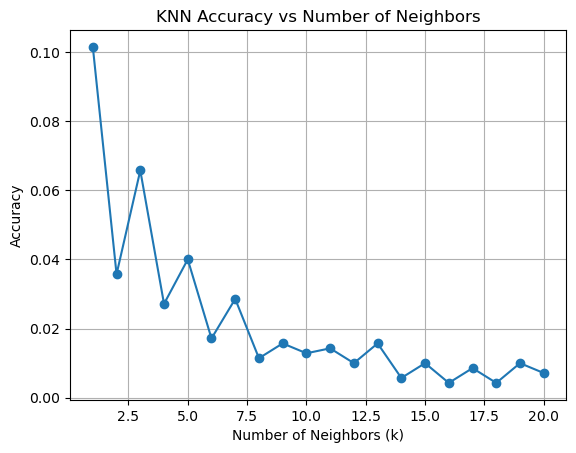

In [24]:
_full_emg = knn_accuracy_vs_num_neighbors(X_full_emg_train_embeddings, encoded_labels_df, X_full_emg_test_embeddings, encoded_test_labels_df)

k=1, Accuracy: 19.14%
k=2, Accuracy: 9.57%
k=3, Accuracy: 15.43%
k=4, Accuracy: 10.29%
k=5, Accuracy: 13.29%
k=6, Accuracy: 7.86%
k=7, Accuracy: 10.00%
k=8, Accuracy: 7.86%
k=9, Accuracy: 9.29%
k=10, Accuracy: 7.86%
k=11, Accuracy: 8.29%
k=12, Accuracy: 6.71%
k=13, Accuracy: 7.43%
k=14, Accuracy: 5.86%
k=15, Accuracy: 6.86%
k=16, Accuracy: 4.86%
k=17, Accuracy: 6.57%
k=18, Accuracy: 5.43%
k=19, Accuracy: 6.00%
k=20, Accuracy: 5.14%


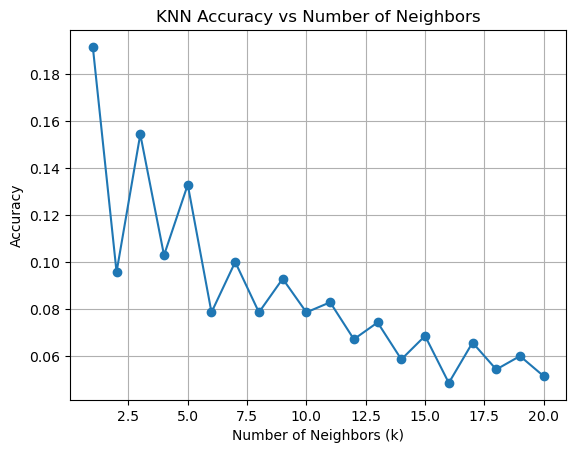

In [25]:
accuracies_full_both = knn_accuracy_vs_num_neighbors(X_full_both_train_embeddings, encoded_labels_df, X_full_both_test_embeddings, encoded_test_labels_df)

k=1, Accuracy: 18.71%
k=2, Accuracy: 11.86%
k=3, Accuracy: 16.86%
k=4, Accuracy: 11.71%
k=5, Accuracy: 14.57%
k=6, Accuracy: 10.86%
k=7, Accuracy: 12.86%
k=8, Accuracy: 9.86%
k=9, Accuracy: 12.00%
k=10, Accuracy: 8.86%
k=11, Accuracy: 10.71%
k=12, Accuracy: 8.57%
k=13, Accuracy: 10.14%
k=14, Accuracy: 7.43%
k=15, Accuracy: 8.57%
k=16, Accuracy: 6.14%
k=17, Accuracy: 7.00%
k=18, Accuracy: 5.14%
k=19, Accuracy: 6.00%
k=20, Accuracy: 4.86%


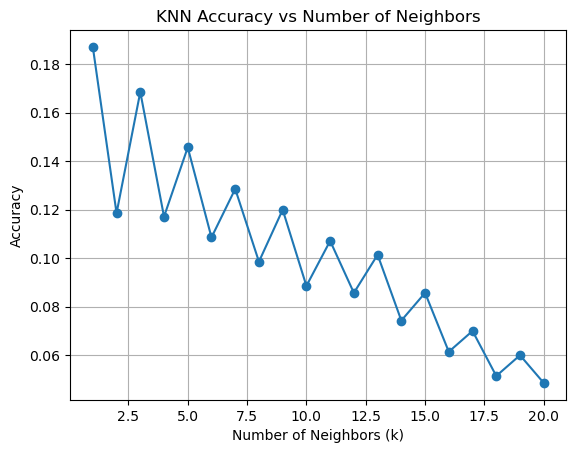

In [26]:
accuracies_both_PCA40 = knn_accuracy_vs_num_neighbors(X_both_PCA40_train_embeddings, encoded_labels_df, X_both_PCA40_test_embeddings, encoded_test_labels_df)

> __SVC__

In [27]:
y_integer = np.argmax(encoded_labels_df, axis=1)
print(len(y_integer))

ytest_integer = np.argmax(encoded_test_labels_df, axis=1)
print(len(ytest_integer))

2500
700


In [28]:
from sklearn.model_selection import GridSearchCV

def svm_hyperparameter_tuning(X_train, y_train, X_test, y_test, kernels=['linear', 'rbf', 'poly', 'sigmoid']):
    """
    Train SVM classifiers with different hyperparameters and plot the accuracy for each kernel.

    Parameters:
    - X_train: Training data embeddings
    - y_train: Training labels
    - X_test: Test data embeddings
    - y_test: Test labels
    - kernels: List of kernel types to test (default: ['linear', 'rbf', 'poly', 'sigmoid'])

    Returns:
    - best_params: Best parameters found for each kernel type
    - best_accuracies: Best accuracy found for each kernel type
    """

    print("Starting")

    # FULL
    #C_lst = [0.1, 1, 10, 100]
    #gamma_lst = [1, 0.1, 0.01, 0.001]
    #param_grid = {
    #    'linear': {'C': C_lst},
    #    'rbf': {'C': C_lst, 'gamma': gamma_lst},
    #    'poly': {'C': C_lst, 'degree': [2, 3, 4], 'gamma': gamma_lst, 'coef0': [0, 1, 10]},
    #    'sigmoid': {'C': C_lst, 'gamma': gamma_lst, 'coef0': [0, 1, 10]}
    #}

    # CONDENSED FOR SPEED...
    C_lst = [0.1, 1, 10]
    gamma_lst = [1, 0.1]
    param_grid = {
        'linear': {'C': C_lst},
        'rbf': {'C': C_lst, 'gamma': gamma_lst},
        'poly': {'C': C_lst, 'degree': [2, 3], 'gamma': gamma_lst, 'coef0': [0, 1]},
        'sigmoid': {'C': C_lst, 'gamma': gamma_lst, 'coef0': [0, 1]}
    }
    
    best_params = {}
    best_accuracies = {}
    
    for kernel in kernels:
        grid = GridSearchCV(SVC(kernel=kernel, random_state=42), param_grid[kernel], refit=True, verbose=0)
        grid.fit(X_train, y_train)
        
        y_pred = grid.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        best_params[kernel] = grid.best_params_
        best_accuracies[kernel] = accuracy
        print(f'Kernel={kernel}, Best Params: {grid.best_params_}, Accuracy: {accuracy*100:.2f}%')
        #print(f"Classification Report for {kernel} kernel:\n", classification_report(y_test, y_pred))
    
    plt.bar(best_accuracies.keys(), best_accuracies.values())
    plt.xlabel('Kernel Type')
    plt.ylabel('Accuracy')
    plt.title('SVM Accuracy vs Kernel Type')
    #plt.grid(True)
    plt.show()
    
    return best_params, best_accuracies

Starting
Kernel=linear, Best Params: {'C': 0.1}, Accuracy: 11.14%
Kernel=rbf, Best Params: {'C': 1, 'gamma': 0.1}, Accuracy: 10.71%
Kernel=poly, Best Params: {'C': 0.1, 'coef0': 1, 'degree': 3, 'gamma': 0.1}, Accuracy: 12.29%
Kernel=sigmoid, Best Params: {'C': 1, 'coef0': 1, 'gamma': 0.1}, Accuracy: 12.57%


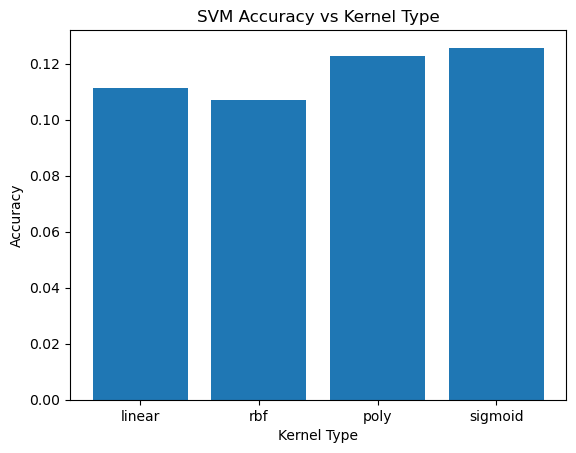

In [29]:
best_params_full_emg, best_accuracies_full_emg = svm_hyperparameter_tuning(X_full_emg_train_embeddings, y_integer, X_full_emg_test_embeddings, ytest_integer)


Starting
Kernel=linear, Best Params: {'C': 1}, Accuracy: 17.14%
Kernel=rbf, Best Params: {'C': 10, 'gamma': 0.1}, Accuracy: 16.43%
Kernel=poly, Best Params: {'C': 0.1, 'coef0': 0, 'degree': 3, 'gamma': 1}, Accuracy: 18.57%
Kernel=sigmoid, Best Params: {'C': 10, 'coef0': 0, 'gamma': 0.1}, Accuracy: 6.86%


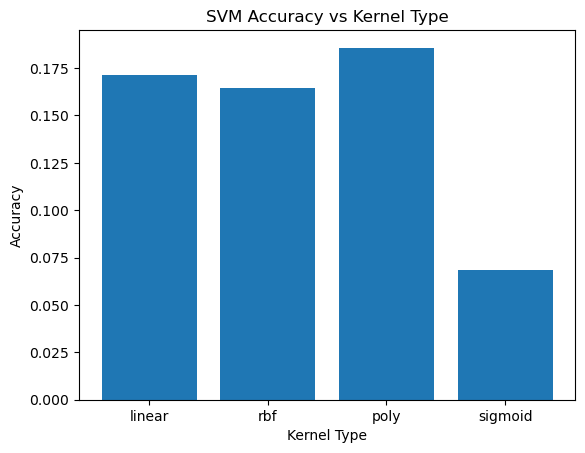

In [30]:
best_params_full_both, best_accuracies_full_both = svm_hyperparameter_tuning(X_full_both_train_embeddings, y_integer, X_full_both_test_embeddings, ytest_integer)


Starting
Kernel=linear, Best Params: {'C': 1}, Accuracy: 17.29%
Kernel=rbf, Best Params: {'C': 10, 'gamma': 0.1}, Accuracy: 15.86%
Kernel=poly, Best Params: {'C': 0.1, 'coef0': 1, 'degree': 3, 'gamma': 0.1}, Accuracy: 22.00%
Kernel=sigmoid, Best Params: {'C': 0.1, 'coef0': 1, 'gamma': 0.1}, Accuracy: 11.57%


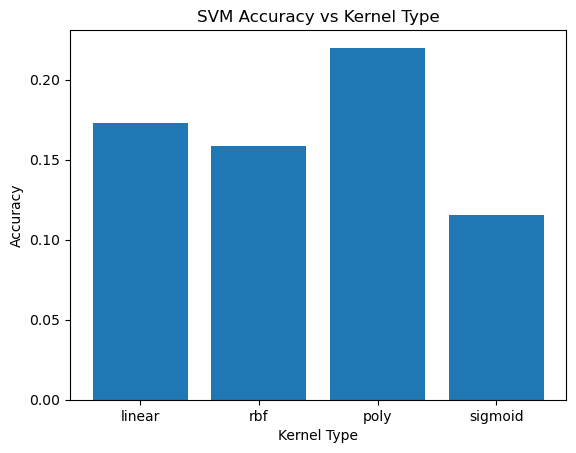

In [31]:
best_params_both_PCA40, best_accuracies_both_PCA40 = svm_hyperparameter_tuning(X_both_PCA40_train_embeddings, y_integer, X_both_PCA40_test_embeddings, ytest_integer)


In [ ]:
assert(False)

Old SVC results

In [32]:
# Create an SVM classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=42)  # You can change kernel to 'rbf', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train_embeddings, y_integer)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(f"Accuracy: {accuracy_score(ytest_integer, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(ytest_integer, y_pred))

NameError: name 'X_train_embeddings' is not defined

In [ ]:
# Create an SVM classifier
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)  # You can change kernel to 'rbf', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train_embeddings, y_integer)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(f"Accuracy: {accuracy_score(ytest_integer, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(ytest_integer, y_pred))

Make the dataloaders for the clustering algorithms (this is only for NNs)

In [ ]:
# CREATE THE TRAINING SET
num_gestures = len(emg_training_users_df) // num_rows_per_gesture
num_features = emg_training_users_df.shape[1]
emg_train_loader = create_data_loader(emg_training_users_df, GestureDatasetClustering, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_features = emg_test_users_df.shape[1]
num_gestures = len(emg_test_users_df) // num_rows_per_gesture
emg_test_loader = create_data_loader(emg_test_users_df, GestureDatasetClustering, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=False)

# CREATE THE TRAINING SET
num_gestures = len(both_training_users_df) // num_rows_per_gesture
num_features = both_training_users_df.shape[1]
both_train_loader = create_data_loader(both_training_users_df, GestureDatasetClustering, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_features = both_test_users_df.shape[1]
num_gestures = len(both_test_users_df) // num_rows_per_gesture
both_test_loader = create_data_loader(both_test_users_df, GestureDatasetClustering, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=False)

# CREATE THE TRAINING SET
num_gestures = len(both_pca_training_users_df) // num_rows_per_gesture
num_features = both_pca_training_users_df.shape[1]
both_pca_train_loader = create_data_loader(both_pca_training_users_df, GestureDatasetClustering, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_features = both_pca_test_users_df.shape[1]
num_gestures = len(both_pca_test_users_df) // num_rows_per_gesture
both_pca_test_loader = create_data_loader(both_pca_test_users_df, GestureDatasetClustering, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=False)